In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

## Data Preprocessing

#### Edges

In [2]:
edges_df = pd.read_csv('edges.csv')

#### Nodes

In [3]:
nodes_df = pd.read_csv('nodes.csv')

In [4]:
nodes_df.loc[nodes_df.node.str.startswith('SPIDER-MAN/P'), 'node'] = "SPIDER-MAN/PETER PARKER"

#### Network

In [5]:
network = pd.read_csv('hero-network.csv')

In [6]:
# drop self-loops
network = network[~(network.hero1 == network.hero2)].reset_index(drop=True)

#### Finding  inconsistencies

In [7]:
h1 = network.hero1.to_list()
h2 = network.hero2.to_list()

In [8]:
# Sets of heros in each df
s_network = set(list(map(str.strip, h1 + h2)))
s_edges = set(edges_df.hero)
s_nodes = set(nodes_df[nodes_df.type=="hero"].node)

In [9]:
# No more inconsistencies in edges_df and nodes_df
(s_nodes - s_edges).union(s_edges - s_nodes)

set()

In [10]:
s_network - s_nodes

{'BLADE', 'SABRE', 'SPIDER-MAN/PETER PAR'}

In [11]:
s_nodes - s_network

{'BERSERKER II',
 'BLADE/',
 'BLARE/',
 'CALLAHAN, DANNY',
 'CLUMSY FOULUP',
 'DEATHCHARGE',
 'FENRIS',
 'GERVASE, LADY ALYSSA',
 'GIURESCU, RADU',
 'JOHNSON, LYNDON BAIN',
 'KULL',
 'LUNATIK II',
 'MARVEL BOY II/MARTIN',
 'RANDAK',
 'RED WOLF II',
 'RUNE',
 'SABRE/',
 'SEA LEOPARD',
 'SHARKSKIN',
 'SPIDER-MAN/PETER PARKER',
 'ZANTOR'}

In [12]:
s_network - s_edges

{'BLADE', 'SABRE', 'SPIDER-MAN/PETER PAR'}

In [13]:
s_edges - s_network

{'BERSERKER II',
 'BLADE/',
 'BLARE/',
 'CALLAHAN, DANNY',
 'CLUMSY FOULUP',
 'DEATHCHARGE',
 'FENRIS',
 'GERVASE, LADY ALYSSA',
 'GIURESCU, RADU',
 'JOHNSON, LYNDON BAIN',
 'KULL',
 'LUNATIK II',
 'MARVEL BOY II/MARTIN',
 'RANDAK',
 'RED WOLF II',
 'RUNE',
 'SABRE/',
 'SEA LEOPARD',
 'SHARKSKIN',
 'SPIDER-MAN/PETER PARKER',
 'ZANTOR'}

## Graphs setup

**First graph** 

Will be constructed using the data stored in the 'hero-network.csv' file, in which an edge between two heroes can be found if they have appeared in the same comic together. The **number of edges** between two heroes represents the **number of times they have collaborated** in different comics. The graph should be considered **weighted and undirected**. It is up to you to decide which metric to use to calculate the weights, but we anticipate that the cost will be lower for heroes with more collaborations. Please specify which metric you used to select the weights in the report.


In [14]:
network

hero1                 hero2
0              LITTLE, ABNER        PRINCESS ZANDA
1              LITTLE, ABNER  BLACK PANTHER/T'CHAL
2       BLACK PANTHER/T'CHAL        PRINCESS ZANDA
3              LITTLE, ABNER        PRINCESS ZANDA
4              LITTLE, ABNER  BLACK PANTHER/T'CHAL
...                      ...                   ...
572230  COLOSSUS II/PETER RA              CALLISTO
572231              CALLISTO               ROGUE /
572232              CALLISTO              CALIBAN/
572233              CALIBAN/               ROGUE /
572234  HULK/DR. ROBERT BRUC     MARKS, DR. SHIELA

[572235 rows x 2 columns]

In [15]:
def get_hero_dict(list_of_heroes):
    index_to_hero = {} 
    hero_to_index = {}

    for ix, hero in enumerate(list_of_heroes):
        index_to_hero[ix] = hero
        hero_to_index[hero] = ix
        
    return index_to_hero, hero_to_index

In [166]:
def create_G1(network_df=network, edges_df=edges_df, N=None):
   
    if N is not None: # if we want to use only top n heroes
        top_heroes = edges_df.groupby(by='hero').count().comic.sort_values(ascending=False)
        top_heroes = edges_df[edges_df["hero"].isin(top_heroes[:N].index)].reset_index(drop=True).hero.unique()
        
    else:
        top_heroes = edges_df.hero.unique()
    
    n = len(top_heroes) # number of nodes in the graph
    
    index_to_hero, hero_to_index = get_hero_dict(top_heroes)
    
    network_A = np.zeros((n, n)) # adjacency matrix

    # fill the matrix
    for ix in range(len(network_df)):
        hero1 = network_df.loc[ix].hero1
        hero2 = network_df.loc[ix].hero2
        
        if hero1 in top_heroes and hero2 in top_heroes:
        
            ix = hero_to_index[hero1]
            jx = hero_to_index[hero2]

            network_A[ix, jx] += 1
            # network_A[jx, ix] += 1
        
    network_A[network_A != 0] = 1 / network_A[network_A != 0]
    
    rows, cols = np.where(network_A != 0)


    edges = zip([index_to_hero[ix] for ix in rows.tolist()], 
                [index_to_hero[jx] for jx in cols.tolist()], 
                network_A[rows, cols])

    G = nx.MultiGraph()
    G.add_weighted_edges_from(edges)
    
    return G

G1 = create_G1()

In [ ]:
plt.rcParams["figure.figsize"] = (20, 20)
pos = nx.spring_layout(G1) # pos = nx.nx_agraph.graphviz_layout(G)
nx.draw_networkx(G1, pos, 
                 node_size=5, 
                 font_size=1,
                 edge_color='grey')
plt.savefig("graph.png", dpi=1000)

**Second graph**

The data in **'nodes.csv'** and **'edges.csv'** will be used to construct the second graph. The **type of node (hero/comic)** can be found in 'nodes.csv', and **an edge** between a hero **node and a comic** node can be found in 'edges.csv' when the hero has appeared in that specific comic. This graph is assumed to be **undirected and unweighted**.

In [17]:
top_heroes = edges_df.groupby(by='hero').count().comic.sort_values(ascending=False)
top_heroes

hero
SPIDER-MAN/PETER PARKER    1577
CAPTAIN AMERICA            1334
IRON MAN/TONY STARK        1150
THING/BENJAMIN J. GR        963
THOR/DR. DONALD BLAK        956
                           ... 
LEASH, MICAH                  1
LEATHER/                      1
SERSI | MUTANT X-VER          1
LEE, LITTLE LARRY             1
24-HOUR MAN/EMMANUEL          1
Name: comic, Length: 6439, dtype: int64

In [18]:
def create_G2(edges_df=edges_df, N=None):
    G = nx.Graph()
    
    if N is not None:
        top_heroes = edges_df.groupby(by='hero').count().comic.sort_values(ascending=False)
        edges_df = edges_df[edges_df["hero"].isin(top_heroes[:N].index)].reset_index(drop=True)
        
    for ex in range(len(edges_df)):
        hero, comic = edges_df.loc[ex]
        
        G.add_node(hero, attr='hero')
        G.add_node(comic, attr='comic')
        
        G.add_edge(hero, comic)
    
    return G

G2 = create_G2()

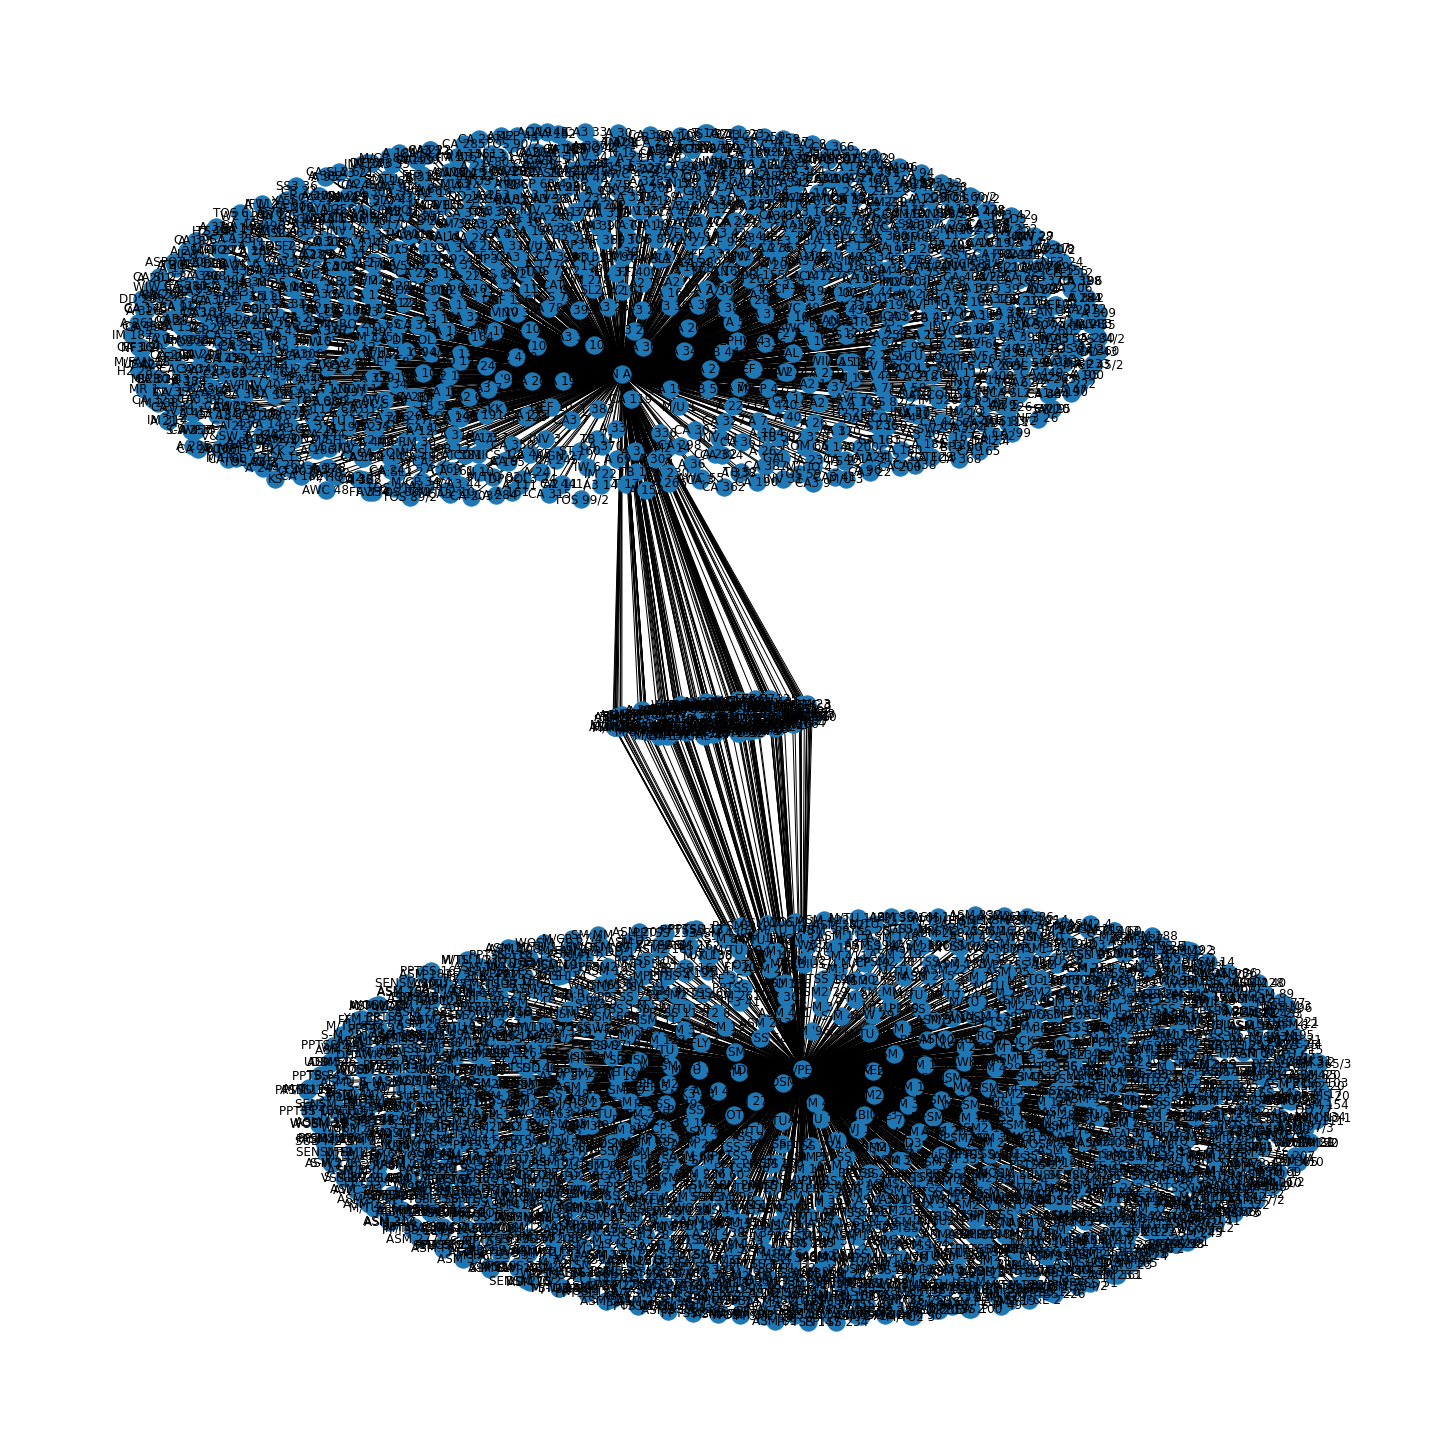

In [ ]:
nx.draw(G2, with_labels='True') #With Top N=2

# 2. Backend Implementation

The goal of this part is the implementation of a controller system that has different functionalities. The controller should take as input an identifier "i" and run the associated function_i applied to the graph you create from the downloaded data.

**Definition**

As the number of nodes and edges grows, we may request to work on a subset of the data to reduce computation time and improve network visualization. In this case, we will ask you only to consider the data for top N heros. We define the top N heroes as follows:

**Top N heroes:** The top N heroes who have appeared in the most number of comics. The 'edges.csv' file, which represents the comics in which each hero has appeared, can be used to filter these N heroes.
Note: When the value of N is not set by the user, the function should consider the whole data.

In [19]:
def get_params(set_n=False):
    print('Please enter the graph type:')
    graph_type = input()
    
    if graph_type not in ['1', '2']:
        raise ValueError('The graph type has to be either \'1\' or \'2\'')
    
    if set_n:
        print('Now enter n for the top n heroes:')
        set_n = input()
        
        if not set_n.isnumeric():
            raise ValueError('Top heroes n has to be an integer.')
        
    return graph_type, int(set_n)

In [20]:
def create_graph(graph_type, n_heroes):
    
    if graph_type == '1':
        if n_heroes:
            G = create_G1(N=n_heroes)
        else:
            G = create_G1()
            
    if graph_type == '2':
        if n_heroes:
            G = create_G2(N=n_heroes)
        else:
            G = create_G2()
    
    return G

## Functionality 1 - extract the graph's features

**Input**

The graph data

The graph type (ex., number 1 or number 2)

N: denoting the top N heroes that their data should be considered

**Output**

The number of nodes in the network (if type 2, report for both node types)

The number of collaborations of each superhero with the others (only if type 1)

The number of heroes that have appeared in each comic (only if type 2)

The network's density

The network's degree distribution

The average degree of the network

The network's Hubs (hubs are nodes having degrees more extensive than the 95th percentile of the degree distribution)

Whether the Network is sparse or dense

Note: For this case, it makes sense to differentiate operations between the two graphs: for example, when computing hubs for the second graph, we likely care only about comics.



In [ ]:
def get_num_collaborations(G):
    V = G.nodes()
    A = nx.adjacency_matrix(G).todense() / 2
    A[A != 0] = np.array((1 / A[A != 0]))[0]

    return list(zip(V, np.array(A).sum(axis=0)))

In [ ]:
def get_network_density(G):
    num_edges = len(G.edges) / 2
    num_nodes = len(G.nodes)
    
    max_possible_edges = (num_nodes * (num_nodes - 1)) / 2
    
    network_density = num_edges/max_possible_edges
    
    return network_density    

In [ ]:
def f1(G, g_type, n_heroes):
    if g_type == '1':
        n_nodes = len(G.nodes)
        
        n_collabs = get_num_collaborations(G)
        
    if g_type == '2':
        
        comic_nodes = [x for x, y in G.nodes(data=True) if y['attr']=='comic']
        hero_nodes = [x for x, y in G.nodes(data=True) if y['attr']=='hero']
        n_nodes = {'comic': len(comic_nodes), 'hero': len(hero_nodes)}
        
        n_heroes_in_each_comic = [(node, G.degree(node)) for node in comic_nodes]
        
    network_density = nx.density(G) if g_type == '2' else get_network_density(G)
    
    degree_sequence = [val/2 if g_type == '1' else val for nod, val in G.degree()]
    average_degree = np.mean(degree_sequence)
    
    is_dense = network_density > 0.95
    
    # missing: hubs, collabs, 
    output = {'n_nodes': n_nodes,
              'density': network_density,
              'degree_sequence': degree_sequence,
              'avg_degree': average_degree,
              'is_dense': is_dense}
    
    return output

In [ ]:
g_type, n_heroes = get_params(True)
G2 = create_graph(g_type, n_heroes)

Please enter the graph type:
2
Now enter n for the top n heroes:
10


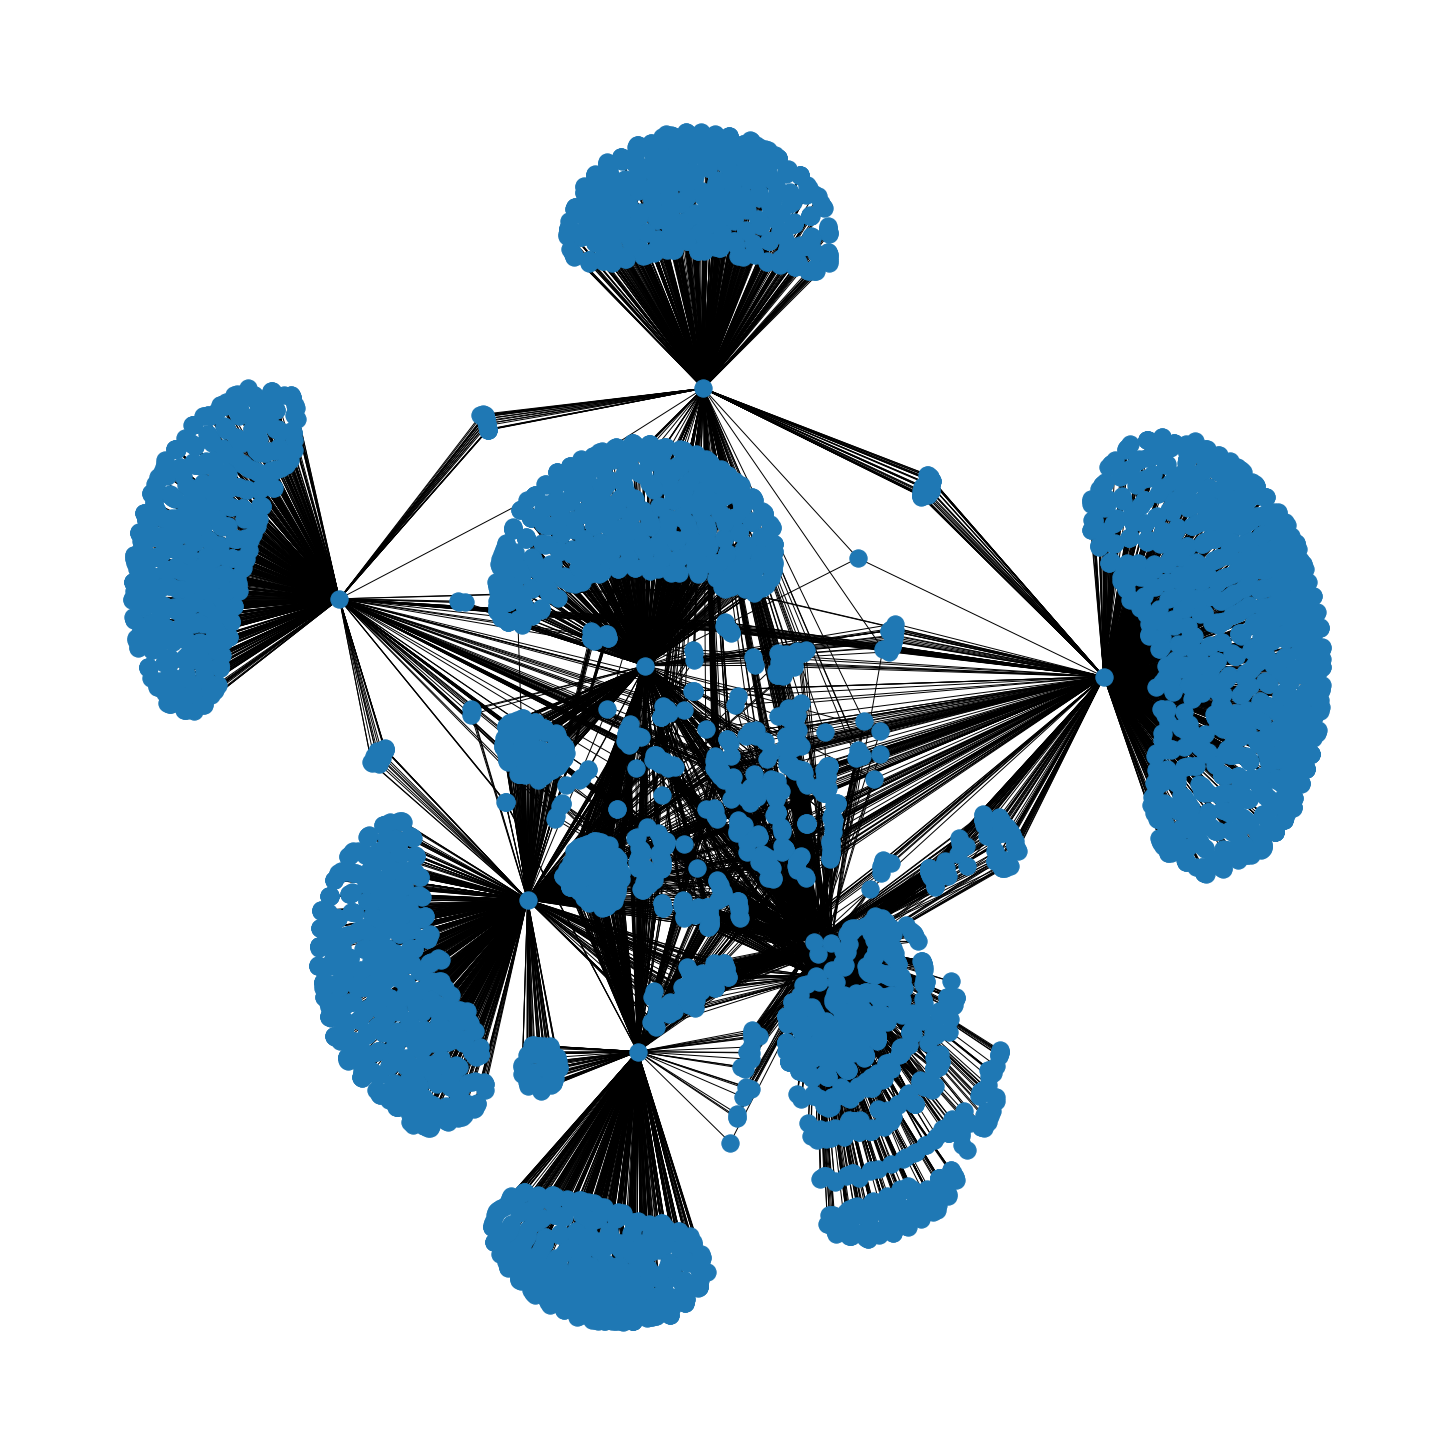

In [ ]:
nx.draw(G2)

In [ ]:
f1(G1, '1', 5)

{'n_nodes': 3,
 'density': 1.0,
 'degree_sequence': [2.0, 2.0, 2.0],
 'avg_degree': 2.0,
 'is_dense': True}

In [ ]:
f1(G2, '2', 4)

{'n_nodes': {'comic': 4149, 'hero': 4},
 'density': 0.0005827205720311756,
 'degree_sequence': [1334,
  2,
  3,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  3,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  4,
  2,
  3,
  2,
  2,
  2,
  3,
  2,
  2,
  2,
  2,
  2,
  2,
  3,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  3,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  3,
  2,
  1,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  1,
  2,
  3,
  2,
  2,
  2,
  1,
  2,
  2,
  2,
  1,
  1,
  1,
  2,
  2,
  2,
  2,
  2,
  1,
  2,
  1,
  2,
  1,
  2,
  2,
  2,
  2,
  2,
  2,
  1,
  2,
  2,
  1,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  1,
  2,
  2,
  2,
  2,
  1,
  2,
  3,
  2,
  2,
  2,
  3,
  2,
  2,
  2,
  1,
  1,
  2,
  3,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  1,
  1,
  1,
  1,
  1,
  2,
  1,
  1,
  2,
  2,
  2,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  2,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  2,
  1,
  1,
  3,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  2,
  2,
  1,
  1,
  2,
  1,
  1

## Visualization 1 - Visualize some features of the network

We anticipate seeing the Functionality 1 report in Visualization 1. To be more specific, we expect you to have the following report format:

A table containing the following general information about the graph:

- Number of nodes in the network
- Density of the network
- Average degree of the network
- Whether the network is sparse or dense
- A table that lists the network's hubs

A plot depicting the number of collaborations of each hero in descending order (if the graph is type 1)

A plot depicting the number of heroes who appeared in each comic, sorted in descending order (if the graph is type 2)

A plot depicting the degree distribution of the network

Note: You can do the plot on a limited number of heroes/comic books to have a better visualization for the charts that ask for some insights about all of the comics/heroes (e.g. for the first 50)

## Functionality 2 - Find top superheroes!

**Input**

The graph data

A node (hero or comic)

One of the given metrics : Betweeness 1, PageRank, ClosenessCentrality 3, DegreeCentrality

N: denoting the top N heroes that their data should be considered

**Output**

The metric's value over the considered graph

The given node's value

Note: Give an explanation regarding the features of the user based on all of the metrics (e.g. if the betweenness metric is high, what does this mean in practice, what if the betweenness is low but has a high PageRank value, etc.).

## Visualization 2 - Visualize centrality measure

We anticipate seeing the Functionality 2 report in Visualization 2. To be more specific, we expect you to have the following report format:

A table containing the information related to the requested centrality measure for:
The average of the requested centrality measure for all of the network's nodes
The requested centrality measure's value for the given node

## Functionality 4 - Disconnecting Graphs
Input:

- The graph data
- heroA: a superhero to which will relate sub-graph G_a
- heroB: a superhero to which will relate sub-graph G_b
- N: denoting the top N heroes that their data should be considered

Output:

- The minimum number of links (by considering their weights) required to disconnect the original graph in two disconnected subgraphs: G_a and G_b.

Graph 1

In [21]:
#With N=10
g_type, n_heroes = get_params(True)
print(g_type)
print(n_heroes)
G1 = create_graph(g_type, n_heroes)

Please enter the graph type:
Now enter n for the top n heroes:
1
10


"nx.to_pandas_adjacency" was used to have a better visualization of edge weights.

In [22]:
G = nx.to_pandas_adjacency(G1)
G

CAPTAIN AMERICA  HULK/DR. ROBERT BRUC  \
CAPTAIN AMERICA              0.000000              0.036180   
HULK/DR. ROBERT BRUC         0.036180              0.000000   
HUMAN TORCH/JOHNNY S         0.025649              0.041113   
MR. FANTASTIC/REED R         0.024100              0.044949   
THING/BENJAMIN J. GR         0.024027              0.040507   
THOR/DR. DONALD BLAK         0.010364              0.055944   

                      HUMAN TORCH/JOHNNY S  MR. FANTASTIC/REED R  \
CAPTAIN AMERICA                   0.025649              0.024100   
HULK/DR. ROBERT BRUC              0.041113              0.044949   
HUMAN TORCH/JOHNNY S              0.000000              0.005614   
MR. FANTASTIC/REED R              0.005614              0.000000   
THING/BENJAMIN J. GR              0.005380              0.005655   
THOR/DR. DONALD BLAK              0.032563              0.031099   

                      THING/BENJAMIN J. GR  THOR/DR. DONALD BLAK  
CAPTAIN AMERICA                   0.024027              0.010364  
HULK/DR. ROBERT BRUC              0.040507              0.055944  
HUMAN TORCH/JOHNNY S              0.005380              0.032563  
MR. FANTASTIC/REED R              0.005655              0.031099  
THING/BENJAMIN J. GR              0.000000              0.031947  
THOR/DR. DONALD BLAK              0.031947              0.000000

Then we pass the weights to a dictionary. This in order to better visualize the relationship between the Hero A and Hero B nodes.

In [23]:
# Create an empty dictionary
result = {}

# Iterate over the rows of the dataframe
for i, row in G.iterrows():
    # Get the character name from the index
    character = i
    # Initialize an empty dictionary for the character
    result[character] = {}
    # Iterate over the columns
    for col_name in G.columns:
        # Get the score value from the row
        score = row[col_name]
        # Add the score to the character's dictionary if it's not 0.000
        if score != 0.000:
            result[character][col_name] = score

print(result)

{'CAPTAIN AMERICA': {'HULK/DR. ROBERT BRUC': 0.03617992177314211, 'HUMAN TORCH/JOHNNY S': 0.02564935064935065, 'MR. FANTASTIC/REED R': 0.024099883855981417, 'THING/BENJAMIN J. GR': 0.02402745995423341, 'THOR/DR. DONALD BLAK': 0.010363807222445967}, 'HULK/DR. ROBERT BRUC': {'CAPTAIN AMERICA': 0.03617992177314211, 'HUMAN TORCH/JOHNNY S': 0.04111295681063123, 'MR. FANTASTIC/REED R': 0.04494949494949495, 'THING/BENJAMIN J. GR': 0.040507364975450086, 'THOR/DR. DONALD BLAK': 0.055944055944055944}, 'HUMAN TORCH/JOHNNY S': {'CAPTAIN AMERICA': 0.02564935064935065, 'HULK/DR. ROBERT BRUC': 0.04111295681063123, 'MR. FANTASTIC/REED R': 0.005614084817561928, 'THING/BENJAMIN J. GR': 0.005380231986346938, 'THOR/DR. DONALD BLAK': 0.03256302521008403}, 'MR. FANTASTIC/REED R': {'CAPTAIN AMERICA': 0.024099883855981417, 'HULK/DR. ROBERT BRUC': 0.04494949494949495, 'HUMAN TORCH/JOHNNY S': 0.005614084817561928, 'THING/BENJAMIN J. GR': 0.0056551779224409925, 'THOR/DR. DONALD BLAK': 0.031099324975891997}, 'THI

Original Graph

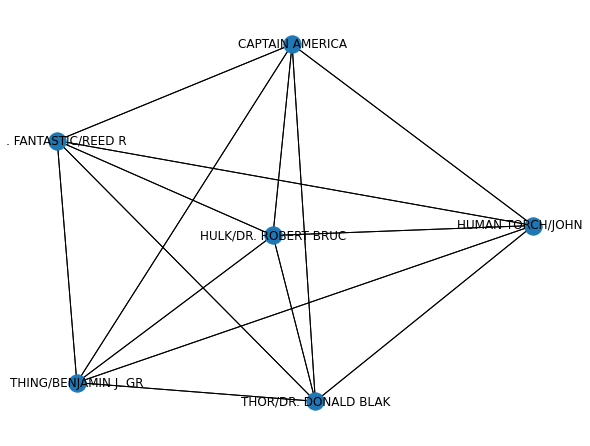

In [24]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))

nx.draw(G1, with_labels=True)

In [25]:
#get_edge_data to obtain the weights of the nodes
G1.get_edge_data('CAPTAIN AMERICA', 'THOR/DR. DONALD BLAK')

{0: {'weight': 0.005235602094240838}, 1: {'weight': 0.005128205128205128}}

In [56]:
#We use nx.Graph to convert the MultiGraph to a Graph
if type(G1) == nx.MultiGraph:
    G1_ = nx.Graph(G1.copy())

In [27]:
G1_.edges('CAPTAIN AMERICA', data=True) #We have as a result one weight and a Graph instead of a MultiGraph

EdgeDataView([('CAPTAIN AMERICA', 'HULK/DR. ROBERT BRUC', {'weight': 0.019230769230769232}), ('CAPTAIN AMERICA', 'HUMAN TORCH/JOHNNY S', {'weight': 0.014285714285714285}), ('CAPTAIN AMERICA', 'MR. FANTASTIC/REED R', {'weight': 0.011904761904761904}), ('CAPTAIN AMERICA', 'THING/BENJAMIN J. GR', {'weight': 0.013157894736842105}), ('CAPTAIN AMERICA', 'THOR/DR. DONALD BLAK', {'weight': 0.005128205128205128})])

In [28]:
sum([da['weight'] for s, t, da in G1_.edges('CAPTAIN AMERICA', data=True)])

0.06370734528629265

The minimum_cut() function in NetworkX takes into account the weights of the edges in the graph when computing the minimum cut. By default, it uses the weight of the edges as the measure of the "cost" of cutting the edge. In that way, we are going to obtain a partitioning of the nodes that defines the minimum cut.

In [29]:
def remove_minimum_cut_edges(G, s, t, capacity_att='weight'):
    G_aux = G.copy()
    #With nx.minimum_cut we obtain the nodes which are necessary to separate Hero A from Hero B.
    _, (nodes_set1, nodes_set2) = nx.minimum_cut(G_aux, s, t, capacity_att)

    #Edges to remove to obtain the two disconnected subgraphs
    edges_to_remove = [
        (s, t) for s, t in G_aux.edges(nodes_set1) if t in nodes_set2]

    G_aux.remove_edges_from(edges_to_remove)
    #G_aux is the final output that has the two disconnected subgraphs
    return len(edges_to_remove), G_aux

Graph 2

In [30]:
#Using N=3

g_type, n_heroes = get_params(True)
print(g_type)
print(n_heroes)
G2 = create_graph(g_type, n_heroes)

Please enter the graph type:
Now enter n for the top n heroes:
2
3


Original Graph

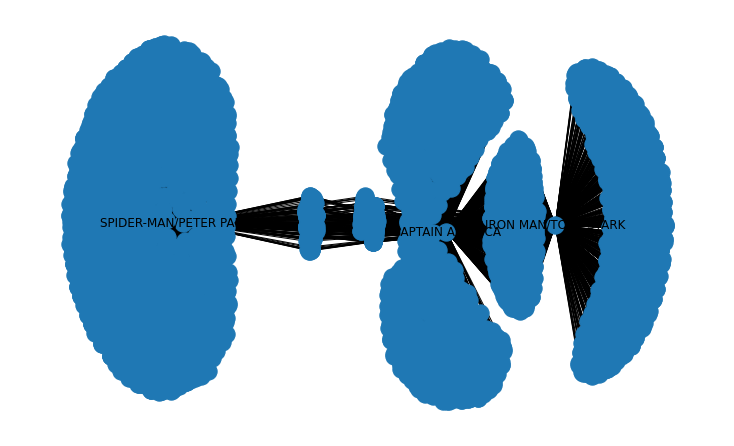

In [55]:
plt.figure(figsize=(10, 6))
# Draw hero nodes
selected_nodes = [node for node in G2.nodes if G2.nodes[node]['attr'] == 'hero']

# Draw a label for just the selected nodes
node_labels = {node:node for node in selected_nodes}
nx.draw(G2, with_labels=True, labels=node_labels)

In [58]:
G2_ = G2.copy()

display(nx.is_weighted(G2_))
#Add a weight of 1 for all nodes and in that way use Minimum_cut later
nx.set_edge_attributes(G2_, 1, "weight")

display(nx.is_weighted(G2_))

False

True

## Visualization 4 - Visualize the disconnected graph

We anticipate seeing the Functionality 4 report in Visualization 4. To be more specific, we expect you to have the following report format:

- Print the number of the links that should be disconnected
- Plot the original graph
- Plot the graph after removing the links and identify the two nodes

Graph 1

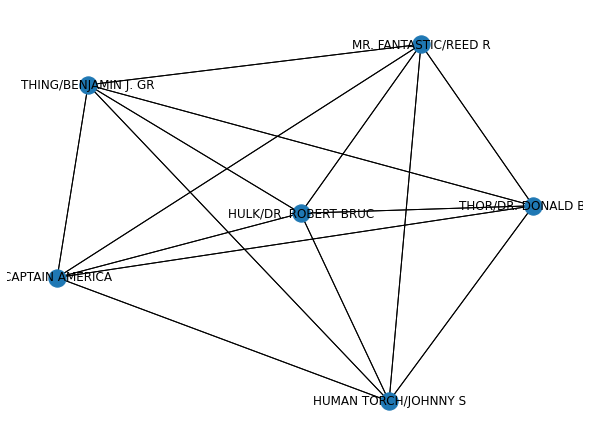

In [51]:
#Original Graph 1.
#As an example, we choose Top N = 10 and Hero A: 'CAPTAIN AMERICA' and Hero B: 'THOR/DR. DONALD BLAK'

plt.figure(figsize=(8, 6))

nx.draw(G1, with_labels=True)

The minuimum number of links (edges) necessary to separate Heroe A from Hero B are: 5


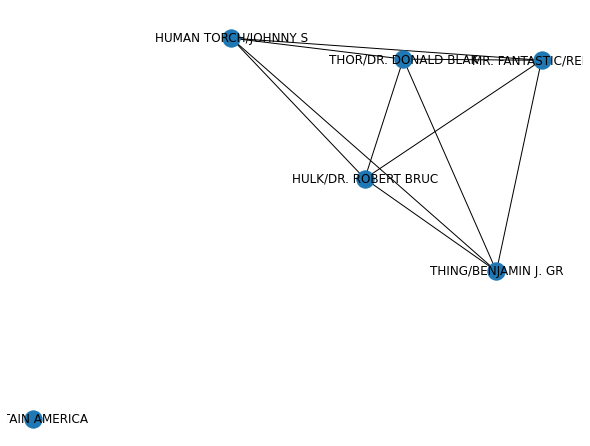

In [50]:
len_edges_to_remove, G3 = remove_minimum_cut_edges(G1_, 'CAPTAIN AMERICA', 'THOR/DR. DONALD BLAK')

print("The minuimum number of links (edges) necessary to separate Heroe A from Hero B are: " + str(len_edges_to_remove))

#Disconnected subgraphs
plt.figure(figsize=(8, 6))
nx.draw(G3, with_labels=True)

Graph 2

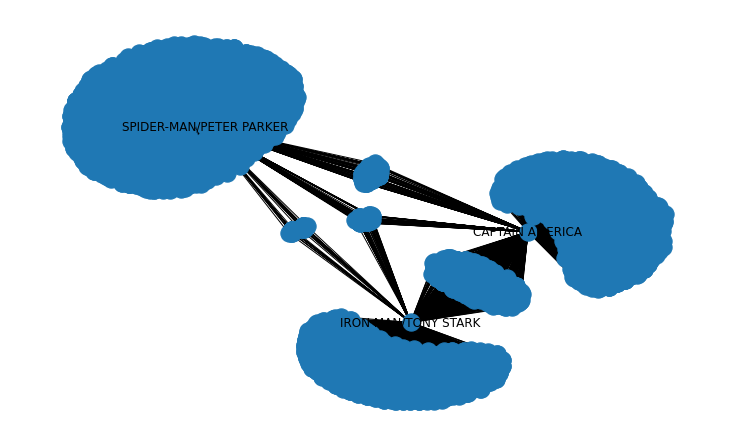

In [57]:
#Original graph
plt.figure(figsize=(10, 6))
# Draw hero nodes
selected_nodes = [node for node in G2.nodes if G2.nodes[node]['attr'] == 'hero']

# Draw a label for just the selected nodes
node_labels = {node:node for node in selected_nodes}
nx.draw(G2, with_labels=True, labels=node_labels)

In [60]:
#As an example, we choose Top N = 3 and Hero A: 'CAPTAIN AMERICA' and Hero B: 'IRON MAN/TONY STARK'.

len_edges_to_remove, G4 = remove_minimum_cut_edges(G2_, 'CAPTAIN AMERICA', 'IRON MAN/TONY STARK')

print("The minuimum number of links (edges) necessary to separate Heroe A from Hero B are: " + str(len_edges_to_remove))

The minuimum number of links (edges) necessary to separate Heroe A from Hero B are: 470


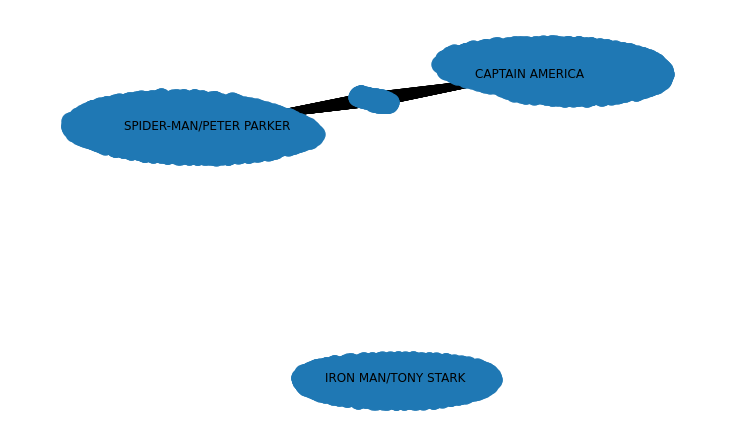

In [61]:
#Disconnected subgraphs
plt.figure(figsize=(10, 6))
# Draw hero nodes
selected_nodes = [node for node in G4.nodes if G4.nodes[node]['attr'] == 'hero']

# Draw a label for just the selected nodes
node_labels = {node:node for node in selected_nodes}
nx.draw(G4, with_labels=True, labels=node_labels)

## Functionality 5 - Extracting Communities

Input:

- The graph data
- N: denoting the top N heroes that their data should be considered
- Hero_1: denoting the name of one of the heroes
- Hero_2: denoting the name of one of the heroes

Output:

- The minimum number of edges that should be removed to form communities
- A list of communities, each containing a list of heroes that belong to them.
- If the Hero_1 and Hero_2 belongs to the same community

Important Notes:
This functionality should only be run on the first graph.

Graph 1

In [173]:
#With N=100
g_type, n_heroes = get_params(True)
print(g_type)
print(n_heroes)
G1 = create_graph(g_type, n_heroes)

Please enter the graph type:
Now enter n for the top n heroes:
1
100


In [174]:
#We use nx.Graph to convert the MultiGraph to a Graph
if type(G1) == nx.MultiGraph:
    G1_ = nx.Graph(G1.copy())

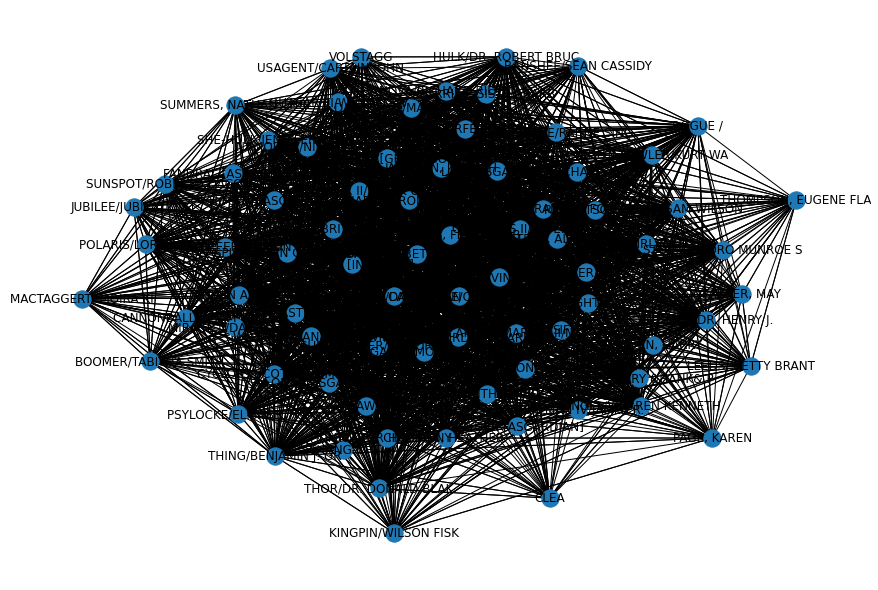

In [175]:
#Original Graph
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))

nx.draw(G1, with_labels=True)

- The edge_to_delete function returns the edge with the highest betweenness centrality in the input graph. 

- The girvan_newman function removes this edge from the graph and then checks the number of connected components in the resulting graph. If the graph still has only one connected component, the process is repeated until the graph has more than one connected component. The resulting connected components are returned as the communities in the graph

In [176]:
#Following the suggestion, the following code was mostly taken from the provided article.

def edge_to_delete(graph):
  #nx.edge_betweenness_centrality is going to return a dictionary of edges with betweenness centrality as the value
  G_EBC = nx.edge_betweenness_centrality(graph)
  edge = ()

  #Edge with highest edge betweenness centrality score
  for edge_dict, key  in sorted(G_EBC.items(), key=lambda item: item[1], reverse = True):
      edge = edge_dict
      break
  return edge

def girvan_newman(graph):
    #number of connected components
    comm = nx.connected_components(graph)
    comp_count = nx.number_connected_components(graph)
    #dictionary to store removed edges
    removed_edges = {}

    #If the number of connected components is greater than 1, the function returns the connected components.
    while(comp_count == 1):
        edge = edge_to_delete(graph)
        graph.remove_edge(edge_to_delete(graph)[0], edge_to_delete(graph)[1])
        comm = nx.connected_components(graph)
        comp_count = nx.number_connected_components(graph)
        removed_edges[edge] = True

    return comm, len(removed_edges)

## Visualization 5 - Visualize the communities

We anticipate seeing the Functionality 5 report in Visualization 5. To be more specific, we expect you to have the following report format:

- Print the number of links that should be removed to have the communities
- A table depicting the communities and the heroes that belong to each community
- Plot the original graph
- Plot the graph showing the communities in the network
- Plot the final graph and identify the community/communities of Hero_1 and Hero_2

Notes:

For the final output of your function, please set the Hero_1 to 'Captain America' and Hero_2 to 'Ironman' and show the results.

If Hero_1 and Hero_2 belong to the same community, identify that community; otherwise, identify those two communities that these heroes belong to.

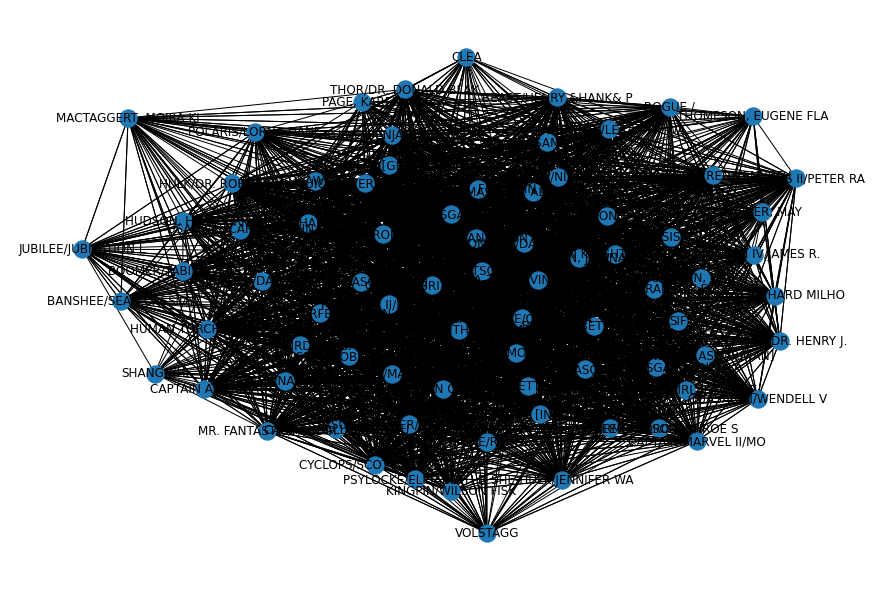

In [177]:
#Original Graph 1.
#As an example, we choose Top N = 100

plt.figure(figsize=(12, 8))

nx.draw(G1, with_labels=True)

In [178]:
#Find communities in the graph
G_aux = G1.copy()
communities, edges_to_remove = girvan_newman(G_aux)

#Nodes in the communities
communitiy_nodes = []

for i in communities:
  communitiy_nodes.append(list(i))

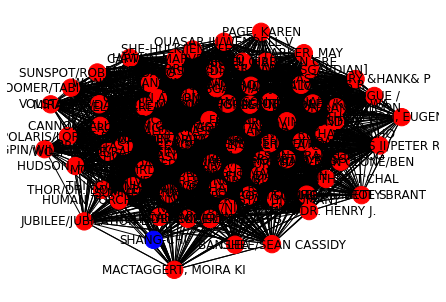

Communities:
Community 1: JAMESON, J. JONAH SUMMERS, NATHAN CHRI DUGAN, TIMOTHY ALOYI PAGE, KAREN PUNISHER II/FRANK CA POLARIS/LORNA DANE NIGHTCRAWLER/KURT WA NORRISS, SISTER BARB MR. FANTASTIC/REED R LOKI [ASGARDIAN] PSYLOCKE/ELISABETH B BEAST/HENRY &HANK& P JUBILEE/JUBILATION L FANDRAL [ASGARDIAN] CYCLOPS/SCOTT SUMMER ANT-MAN/DR. HENRY J. MACTAGGERT, MOIRA KI DAREDEVIL/MATT MURDO ROGUE / WONG HOGUN [ASGARDIAN] CRYSTAL [INHUMAN] VOLSTAGG THING/BENJAMIN J. GR CAPTAIN AMERICA COLOSSUS II/PETER RA HAWK MASTERS, ALICIA REIS TIGRA/GREER NELSON NOVA/RICHARD RIDER IRON FIST/DANIEL RAN WONDER MAN/SIMON WIL QUASAR III/WENDELL V BOOMER/TABITHA SMITH USAGENT/CAPTAIN JOHN ANGEL/WARREN KENNETH MOCKINGBIRD/DR. BARB NAMORITA/NITA PRENTI CAPTAIN BRITAIN/BRIA BANSHEE/SEAN CASSIDY HERCULES [GREEK GOD] CLEA KA-ZAR/KEVIN PLUNDER STORM/ORORO MUNROE S BLACK PANTHER/T'CHAL OSBORN, HARRY JONES, RICHARD MILHO CANNONBALL II/SAM GU BINARY/CAROL DANVERS SILVER SURFER/NORRIN PARKER, MAY SPIDER-MAN CLONE/BEN ROBER

In [179]:
#Communities
graph_plot = []
for node in G1:
    if node in communitiy_nodes[0]:
        graph_plot.append('red')
    else: 
        graph_plot.append('blue')  

nx.draw(G1, node_color=graph_plot, with_labels=True)
plt.show()

print('Communities:')
for i, community in enumerate(communitiy_nodes):
    print(f'Community {i+1}:', *community)

print('Edges to remove: ' + str(edges_to_remove))

Community 1 is identified in red and Community 2 in blue.

In [180]:
def in_same_community(heroA, heroB, communities):
    for community in communities:
        if heroA in community and heroB in community:
            return True
    return False

heroA = 'CAPTAIN AMERICA'
heroB = 'IRON MAN IV/JAMES R.'

if in_same_community(heroA, heroB, communitiy_nodes):
    print(f"{heroA} and {heroB} are in the same community.")
else:
    print(f"{heroA} and {heroB} are in different communities.")

CAPTAIN AMERICA and IRON MAN IV/JAMES R. are in the same community.
